In [1]:
import os
import pandas as pd
import tensorflow as tf
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [2]:
# Cargar la ResNet50 preentrenada sin la capa de clasificación
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(112, 112, 3),pooling='avg')

# Aplicar pooling global después de las capas convolucionales
x = GlobalAveragePooling2D()(resnet_base.output)

# Añadir una capa densa para el procesamiento de las imágenes
x = Dense(256, activation='relu')(x)


In [3]:
# Cargar el archivo
file_path = 'dataset_con_metadatos.h5'
with h5py.File(file_path, 'r') as f:
    images = np.array(f['images'])  
    sex = np.array(f['sex'])        
    age = np.array(f['age'])        
    #localization = np.array(f['localization'])  
    labels = np.array(f['classification'])  

In [4]:
# Normalizar el metadato edad
scaler = StandardScaler()
age_normalized = scaler.fit_transform(age.reshape(-1, 1))

# One-Hot Encoding para sexo y localización
encoder = OneHotEncoder(sparse_output=False)
sex_encoded = encoder.fit_transform(sex.reshape(-1, 1))
# localization_encoded = encoder.fit_transform(localization.reshape(-1, 1))

# Concatenar los metadatos
metadata = np.concatenate([age_normalized, sex_encoded], axis=1) #Se quitó la localización porque tiene mucahs más filas que los otros metadatos e imágenes


In [5]:
# Primero, dividir entre entrenamiento (70%) y test+validación (30%)
X_train, X_test, metadata_train, metadata_test, y_train, y_test = train_test_split(
    images, metadata, labels, test_size=0.30, random_state=42)

# Luego dividir la parte test en validación (10%) y prueba (20%)
X_val, X_test, metadata_val, metadata_test, y_val, y_test = train_test_split(
    X_test, metadata_test, y_test, test_size=2/3, random_state=42)


In [6]:
# Entrada para los metadatos
metadata_input = Input(shape=(3,))  # num_metadata_features es el número de características de los metadatos

# Fusionar las características extraídas de ResNet con los metadatos
combined = Concatenate()([x, metadata_input])

# Añadir capas adicionales al modelo combinado
combined_output = Dense(128, activation='relu')(combined)
combined_output = Dense(2, activation='sigmoid')(combined_output)  # Para clasificación binaria (maligno/benigno)

# Definir el modelo completo
model = Model(inputs=[resnet_base.input, metadata_input], outputs=combined_output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [7]:
from sklearn.utils import class_weight

# Convertir etiquetas one-hot a etiquetas con una sola clase
#labels_single_class = np.argmax(labels, axis=1)
# Calcular los pesos de clase
#class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels_single_class), y=labels_single_class)

# Convertir el resultado a un diccionario, si es necesario
class_weights_dict = dict(enumerate(class_weights))

# Entrenar el modelo
#history = model.fit([images, metadata], labels, batch_size=32, epochs=10, validation_split=0.2,class_weight=class_weights_dict)
history = model.fit([images, metadata], labels, batch_size=32, epochs=10, validation_split=0.2,)

# Mostrar el resumen del modelo
model.summary()


Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.7301 - loss: 0.5411 - val_accuracy: 0.1461 - val_loss: 3517.7419
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.7760 - loss: 0.4406 - val_accuracy: 0.1461 - val_loss: 4.9450
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.8062 - loss: 0.4106 - val_accuracy: 0.1461 - val_loss: 189.0612
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.8088 - loss: 0.4027 - val_accuracy: 0.1461 - val_loss: 1.6091
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.8291 - loss: 0.3731 - val_accuracy: 0.1461 - val_loss: 4.0602
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.8445 - loss: 0.3292 - val_accuracy: 0.2473 - val_loss: 2.7275
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.8637 - loss: 0.3086 - val_accuracy: 0.4232 - val_loss: 1.2267
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.8798 - loss: 0.2845 - val

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 118, 118,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 56, 56,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 56, 56,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 56, 56,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 58, 58,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 28, 28,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 28, 28,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 28, 28,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 28, 28,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 28, 28,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 28, 28,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 28, 28,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 28, 28,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 28, 28,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 28, 28,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 28, 28,    │      1,024 │ conv2_block1_3_c

 Total params: 72,331,144 (275.92 MB)

 Trainable params: 24,092,674 (91.91 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 48,185,350 (183.81 MB)

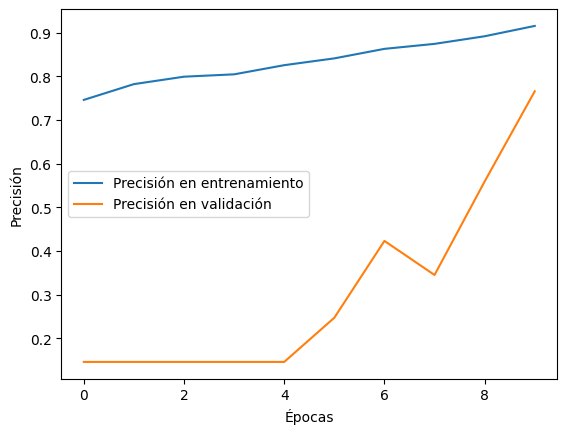

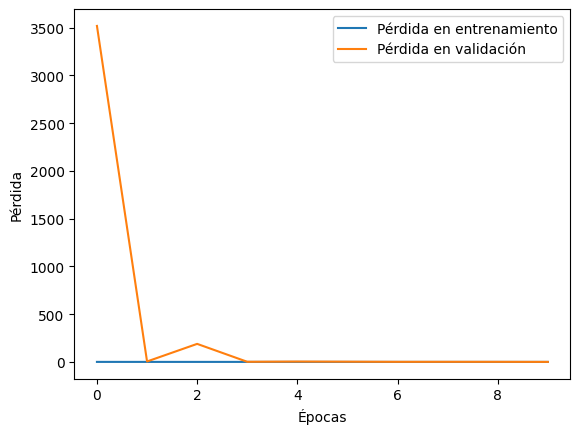

In [8]:
#### resultados #####

# Curvas de precisión
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Curvas de pérdida
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 537ms/step


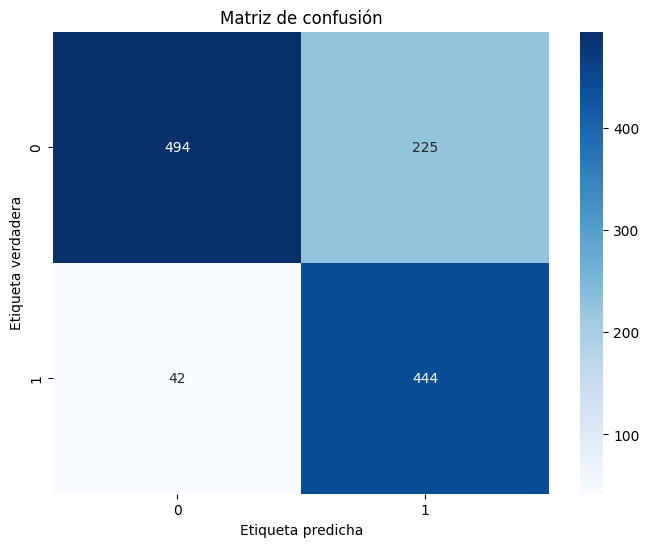

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.92      0.69      0.79       719
           1       0.66      0.91      0.77       486

    accuracy                           0.78      1205
   macro avg       0.79      0.80      0.78      1205
weighted avg       0.82      0.78      0.78      1205



In [9]:
# Predecir en el conjunto de prueba
y_pred = model.predict([X_test, metadata_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')
plt.title('Matriz de confusión')
plt.show()
# Reporte de clasificación
print("Reporte de clasificación:\n", classification_report(y_true, y_pred_classes))

AUC-ROC: 0.91


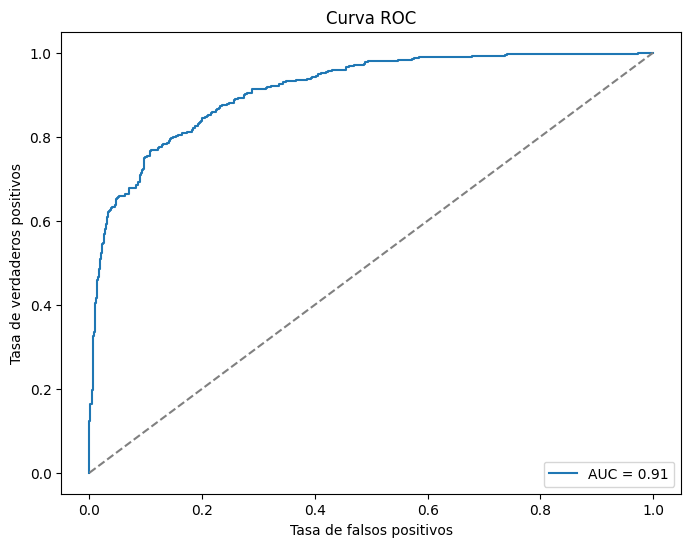

In [10]:

# Calcular AUC-ROC
y_pred_proba = y_pred[:, 1]
auc = roc_auc_score(y_true, y_pred_proba)
print(f'AUC-ROC: {auc:.2f}')

# Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.save('modelo_res.keras')